In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Install NLTK
!pip install nltk
import nltk
nltk.download('vader_lexicon')

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pyspark
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

from sklearn.metrics import r2_score



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
 # Initialize a Spark session
spark = SparkSession.builder \
     .appName("AmazonProductReviews") \
     .getOrCreate()

# Load data into a Spark DataFrame
 df_spark = spark.read.csv('/content/Amazon_Product_Reviews.csv', header=True, inferSchema=True)
 df_spark.show()

In [ ]:
# Load the data
df = pd.read_csv('/content/Amazon_Product_Reviews.csv')
df.head()

,Product ID,Product Name,Asins,Categories,Review Date,Recommended,Reviews_Helpful,Reviews_Ratings,Review_Text,Review_Title
0,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-09-03T00:00:00.000Z,False,0,3,I thought it would be as big as small paper bu...,Too small
1,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-06-06T00:00:00.000Z,True,0,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-20T00:00:00.000Z,True,0,4,Didnt know how much i'd use a kindle so went f...,Great for the price
3,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-11-02T17:33:31.000Z,True,3,5,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-24T00:00:00.000Z,True,0,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [ ]:
df.columns

Index(['Product ID', 'Product Name', 'Asins', 'Categories', 'Review Date',
       'Recommended', 'Reviews_Helpful', 'Reviews_Ratings', 'Review_Text',
       'Review_Title'],
      dtype='object')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.count()

Product ID         4987
Product Name       4987
Asins              4987
Categories         4987
Review Date        4987
Recommended        4987
Reviews_Helpful    4987
Reviews_Ratings    4987
Review_Text        4987
Review_Title       4987
dtype: int64

In [ ]:
id_count = df['Product Name'].value_counts()
id_count

Product Name
Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                                                     833
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                            797
Amazon - Echo Plus w/ Built-In Hub - Silver                                                                                         590
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                              561
Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue                                                             467
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                               371
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker                                                                               225
Fire Kids Edition Tablet, 7 Display

In [ ]:
for id in id_count[id_count<100].index:
  df['Product Name'] = df['Product Name'].replace(id, 'Other')

In [ ]:
review_counts = df['Review_Title'].value_counts()
review_counts

Review_Title
Great tablet                    122
Great product                    78
Love it                          68
Great                            63
Awesome                          51
                               ... 
Not kid friendly                  1
Great tapblet                     1
User friendly, easy set up        1
Unfortunate                       1
Very sturdy for a 5 year old      1
Name: count, Length: 3124, dtype: int64

In [ ]:
for rev in review_counts[review_counts<6].index:
  df['Review_Title'] = df['Review_Title'].replace(rev, 'Other')

In [ ]:
df['Review_Title'].value_counts()

Review_Title
Other            3851
Great tablet      122
Great product      78
Love it            68
Great              63
                 ... 
Great tablet.       6
Great Item          6
Great speaker       6
Gift                6
Nice                6
Name: count, Length: 72, dtype: int64

In [ ]:
# Drop unnecessary columns in dataset
df.drop(['Product ID', 'Asins', 'Reviews_Helpful',  'Review Date'], axis=1, inplace=True)
df.rename(columns={'Reviews_Ratings': 'ratings', 'Review_Text': 'reviews'}, inplace=True)
df.head()

,Product Name,Categories,Recommended,ratings,reviews,Review_Title
0,Other,Electronics,False,3,I thought it would be as big as small paper bu...,Other
1,Other,Electronics,True,5,This kindle is light and easy to use especiall...,Other
2,Other,Electronics,True,4,Didnt know how much i'd use a kindle so went f...,Other
3,Other,Electronics,True,5,I am 100 happy with my purchase. I caught it o...,Other
4,Other,Electronics,True,5,Solid entry level Kindle. Great for kids. Gift...,Other


In [ ]:
import textblob
from textblob import TextBlob

Analyzing the 'Sentiment_num'

In [ ]:
df.Review_Title.value_counts()

Review_Title
Other            3851
Great tablet      122
Great product      78
Love it            68
Great              63
                 ... 
Great tablet.       6
Great Item          6
Great speaker       6
Gift                6
Nice                6
Name: count, Length: 72, dtype: int64

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.head()

,Product Name,Categories,Recommended,ratings,reviews,Review_Title
0,Other,Electronics,False,3,I thought it would be as big as small paper bu...,Other
1,Other,Electronics,True,5,This kindle is light and easy to use especiall...,Other
2,Other,Electronics,True,4,Didnt know how much i'd use a kindle so went f...,Other
3,Other,Electronics,True,5,I am 100 happy with my purchase. I caught it o...,Other
4,Other,Electronics,True,5,Solid entry level Kindle. Great for kids. Gift...,Other


In [ ]:
# Create a new column 'sentiment' to score sentiment scores
df['sentiment'] = 0.0

# Iterate over each row in the DataFrame
for i,row in df.iterrows():
  # Create a TextBlob object from the text in the 'Review_Text' column
  blob = TextBlob(row.reviews)
  # Get the sentiment polarity and round it to 2 decimal places
  sentiment_score = round(blob.sentiment.polarity,2)
  df.at[i, 'sentiment'] = sentiment_score

df.head()

,Product Name,Categories,Recommended,ratings,reviews,Review_Title,sentiment
0,Other,Electronics,False,3,I thought it would be as big as small paper bu...,Other,-0.11
1,Other,Electronics,True,5,This kindle is light and easy to use especiall...,Other,0.28
2,Other,Electronics,True,4,Didnt know how much i'd use a kindle so went f...,Other,0.17
3,Other,Electronics,True,5,I am 100 happy with my purchase. I caught it o...,Other,0.24
4,Other,Electronics,True,5,Solid entry level Kindle. Great for kids. Gift...,Other,0.47


In [ ]:
df.sentiment.sort_values()

1698   -0.98
3672   -0.94
4091   -0.75
561    -0.75
2332   -0.67
        ... 
1551    1.00
2470    1.00
3843    1.00
1439    1.00
1550    1.00
Name: sentiment, Length: 4987, dtype: float64

In [ ]:
df[df.sentiment==-0.98].reviews

1698    My son is obsessed with his kids kindle!! A mu...
Name: reviews, dtype: object

In [ ]:
TextBlob(df.iloc[1698].reviews).sentiment

Sentiment(polarity=0.1797619047619048, subjectivity=0.45714285714285713)

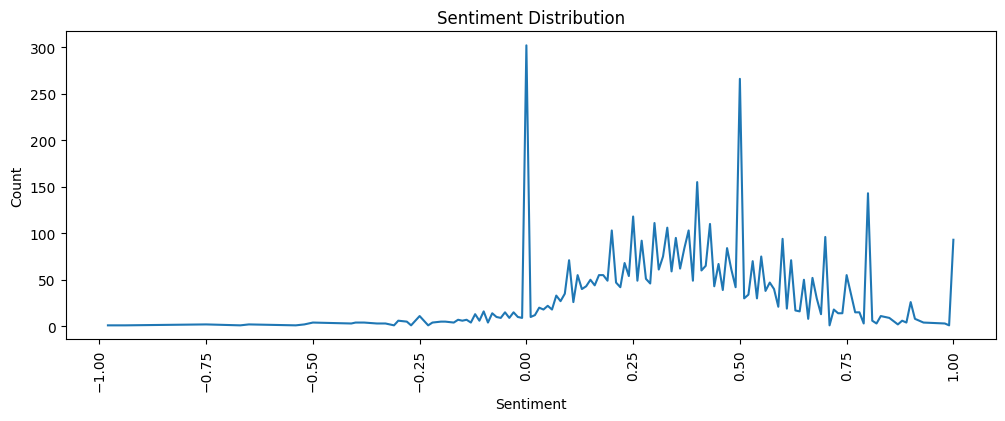

In [ ]:
# Plot sentiment
df['sentiment'].value_counts().sort_index().plot(figsize=(12,4), rot=90)

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
# Define the function to assign 'positieve/negative' sentiment based on rating
def assign_sentiment(rating):
    if rating >= 3:
        return 1
    else:
        return 0

# Apply the function to the 'ratings' column
df['ratings'] = df['ratings'].apply(assign_sentiment)

In [ ]:
df.head()

,Product Name,Categories,Recommended,ratings,reviews,Review_Title,sentiment
0,Other,Electronics,False,1,I thought it would be as big as small paper bu...,Other,-0.11
1,Other,Electronics,True,1,This kindle is light and easy to use especiall...,Other,0.28
2,Other,Electronics,True,1,Didnt know how much i'd use a kindle so went f...,Other,0.17
3,Other,Electronics,True,1,I am 100 happy with my purchase. I caught it o...,Other,0.24
4,Other,Electronics,True,1,Solid entry level Kindle. Great for kids. Gift...,Other,0.47


In [ ]:
def preprocess_text(texts):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')  # Keep 'not' in the stop words list

    processed_texts = []
    for text in texts:
        # Convert to lowercase
        text = text.lower()
        # Remove digits
        text = re.sub(r'\d+', '', text)
        # Remove all non-alphanumeric characters (including punctuation)
        text = re.sub(r'\W+', ' ', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize the tokens
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

        # Join tokens back to string and append to list
        processed_texts.append(' '.join(tokens))

    return processed_texts


In [ ]:
# # Extract the reviews column
# train_reviews = train['reviews']
# test_reviews = test['reviews']

# # Preprocess the reviews
# processed_train_reviews = preprocess_text(train_reviews)
# processed_test_reviews = preprocess_text(test_reviews)

In [ ]:
df['reviews'] = df['reviews'].astype(str)
# Add word count column
df['word_count'] = df['reviews'].apply(lambda x: len(x.split()))

# Display the processed reviews
for review, word_count in zip(df['reviews'][:2], df['word_count'][:2]):
    print(f"Review: {review}\nWord Count: {word_count}\n")





Review: I thought it would be as big as small paper but turn out to be just like my palm. I think it is too small to read on it... not very comfortable as regular Kindle. Would definitely recommend a paperwhite instead.
Word Count: 41

Review: This kindle is light and easy to use especially at the beach!!!
Word Count: 12



In [ ]:
df1 = pd.get_dummies(df, dtype=int)
df1.head()

,Recommended,ratings,sentiment,word_count,"Product Name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",Product Name_Amazon - Echo Plus w/ Built-In Hub - Silver,"Product Name_Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",Product Name_Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,"Product Name_Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue","Product Name_Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum",...,Review_Title_Perfect for kids,Review_Title_Tablet,Review_Title_Works great,Review_Title_good,Review_Title_good product,Review_Title_great,Review_Title_great for kids,Review_Title_great product,Review_Title_great tablet,Review_Title_love it
0,False,1,-0.11,41,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,1,0.28,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,1,0.17,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,True,1,0.24,148,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,True,1,0.47,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df1.columns

Index(['Recommended', 'ratings', 'sentiment', 'word_count',
       'Product Name_All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
       'Product Name_Amazon - Echo Plus w/ Built-In Hub - Silver',
       'Product Name_Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen',
       'Product Name_Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker',
       'Product Name_Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue',
       'Product Name_Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum',
       ...
       'Review_Title_Perfect for kids', 'Review_Title_Tablet',
       'Review_Title_Works great', 'Review_Title_good',
       'Review_Title_good product', 'Review_Title_great',
       'Review_Title_great for kids', 'Review_Title_great product',
       'Review_Title_great tablet', 'Review_Title_love it'],
      dtype='object', length=4466)

In [ ]:
# Extract features and target variable from train and test DataFrames
y = df1['ratings'].values
X = df1.drop('ratings', axis=1)

y_test = df1['ratings'].values
X_test = df1.drop('ratings', axis=1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_test.shape

(998,)

In [ ]:
# # Initialize the Tokenizer
# tokenizer = Tokenizer(num_words= 10000)

# # Fit the tokenizer on the training data
# tokenizer.fit_on_texts(X_train['reviews'])

# # Convert the training and testing data into sequences of integers
# # Each word is replaces by its corresponding integer index from the Tokenizer's word index

# X_train['token_text'] = tokenizer.texts_to_sequences(X_train['reviews'].values)
# X_test['token_text'] = tokenizer.texts_to_sequences(X_test['reviews'].values)

In [ ]:
# # Drop the original reviews column after tonkenization
# X_train = X_train.drop('reviews', axis=1)
# X_test = X_test.drop('reviews', axis=1)

In [ ]:
X_train.shape

(3989, 4465)

In [ ]:
X_test.shape

(998, 4465)

In [ ]:
#Normalize the features
scaler = StandardScaler()

# Fit and transform the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define the number of features
n_features = X_train_scaled.shape[1]

In [ ]:
# Define the model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=80, input_dim=n_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation="relu")) #sigmoid

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 80)                357280    
                                                                 
 dense_10 (Dense)            (None, 30)                2430      
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 359741 (1.37 MB)
Trainable params: 359741 (1.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
len(X_train_scaled)

3989

In [ ]:
#Train model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
125/125 [==============================] - 2s 6ms/step - loss: 0.1519 - accuracy: 0.9616
Epoch 2/100
125/125 [==============================] - 1s 6ms/step - loss: 0.0487 - accuracy: 0.9822
Epoch 3/100
125/125 [==============================] - 1s 6ms/step - loss: 0.0129 - accuracy: 0.9967
Epoch 4/100
125/125 [==============================] - 1s 7ms/step - loss: 0.0022 - accuracy: 0.9997
Epoch 5/100
125/125 [==============================] - 1s 9ms/step - loss: 7.2702e-04 - accuracy: 1.0000
Epoch 6/100
125/125 [==============================] - 1s 9ms/step - loss: 4.0399e-04 - accuracy: 1.0000
Epoch 7/100
125/125 [==============================] - 1s 9ms/step - loss: 2.5629e-04 - accuracy: 1.0000
Epoch 8/100
125/125 [==============================] - 1s 8ms/step - loss: 1.7443e-04 - accuracy: 1.0000
Epoch 9/100
125/125 [==============================] - 1s 6ms/step - loss: 1.2751e-04 - accuracy: 1.0000
Epoch 10/100
125/125 [==============================] - 1s 5ms/step - l

In [ ]:
 # Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

32/32 - 0s - loss: -3.7372e+09 - accuracy: 0.0000e+00 - 191ms/epoch - 6ms/step
Loss: -3737181696.0, Accuracy: 0.0


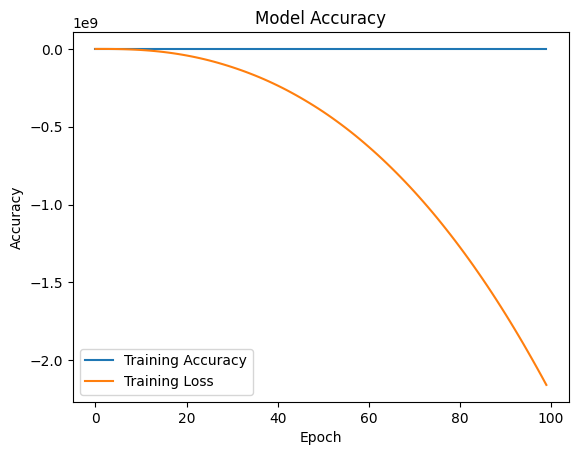

In [ ]:
# Plot accuracy values
plt.plot(fit_model.history['accuracy'], label='Training Accuracy')
plt.plot(fit_model.history['loss'], label='Training Loss')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# # Export our model to HDF5 file
# nn.save("SentimentAnalysis.h5")